# Segment audio files using peak density

In [49]:
%matplotlib inline

from __future__ import division
import numpy as np
import librosa
from itertools import compress
import matplotlib.pyplot as plt
import os
from collections import Counter

def find_silence(y, sr, ind_i, window_len=0.18, thres=0.048):
    hop = int(round(sr * window_len)) 
    width = int(round(sr * window_len))
    n_slice = len(y) // hop
    starts = np.arange(n_slice)*hop
    ends = starts+width
    if hop != width:
        cutoff = np.argmax(ends>len(y))
        starts = starts[:cutoff]
        ends = ends[:cutoff]
        n_slice = len(starts)
    pows = map(lambda i: np.dot(y[starts[i]:ends[i]], y[starts[i]:ends[i]])/width, range(n_slice))
    mask = np.array(list(pows)) < thres * np.dot(y,y)/len(y)
    starts = list(compress(starts+ind_i, mask))
    ends = list(compress(ends+ind_i, mask))
    return zip(starts,ends)

def merger(tulist):
    tu=()
    for tt in tulist:
         tu += tt
    cnt = Counter(tu)
    res = list(filter(lambda x: cnt[x]<2, tu))
    return list(map(lambda x: tuple(x),np.array(res).reshape((len(res)//2,2))))

def shade_silence(filename,start=0,end=None,disp=True,output=False, itr=''):
    """Find signal (as output) or silence (as shaded reagion  in plot) in a audio file
    filename: (filepath) works best with .wav format
    start/end: (float or int) start/end time for duration of interest in second (default= entire length)
    disp: (bool) whether to display a plot(default= True)
    output: (bool) whether to return an output (default = False)
    itr: (int) iteration use for debugging purpose
    """
    y, sr = librosa.load(filename)

    t = np.arange(len(y))/sr

    i = int(round(start * sr))
    
    if end != None:
        j = int(round(end * sr))
    else:
        j = len(y)

    fills = find_silence(y[i:j], sr, i)
    
    if disp:
        fig, ax = plt.subplots()
        ax.set_title(filename)
        ax.plot(t[i:j],y[i:j])
        fig.set_size_inches(18.5, 10.5)

    if fills != None:
        shades = list(map(lambda x: (max(x[0],i),min(x[1],j)), fills))
        if len(shades) > 0:
            shades = merger(shades)
            if disp:
                for s in shades:
                    ax.axvspan(s[0]/sr, s[1]/sr, alpha=0.5, color='red')
                    
    if len(shades)>1:
        live = list(map(lambda i: (shades[i][1],shades[i+1][0]), range(len(shades)-1)))
    elif len(shades)==1:
        a = [i,shades[0][0],shades[0][1],j]
        live = list(filter(lambda x: x != None, 
                           map(lambda x: tuple(x) if x[0]!=x[1] else None,
                               np.sort(a).reshape((len(a)//2, 2)))))
    else:
        live = [(i,j)]

    if output:
        return live, sr, y

def get_segments(filepathlist, disp=False):
    active=[]
    srs=[]
    ys=[]
    for i, fn in enumerate(filepathlist):
        tlist, sr, y = shade_silence(fn, disp=disp, output=True, itr=i)
        active.append(tlist)
        srs.append(sr)
        ys.append(y)
    return active, srs, ys

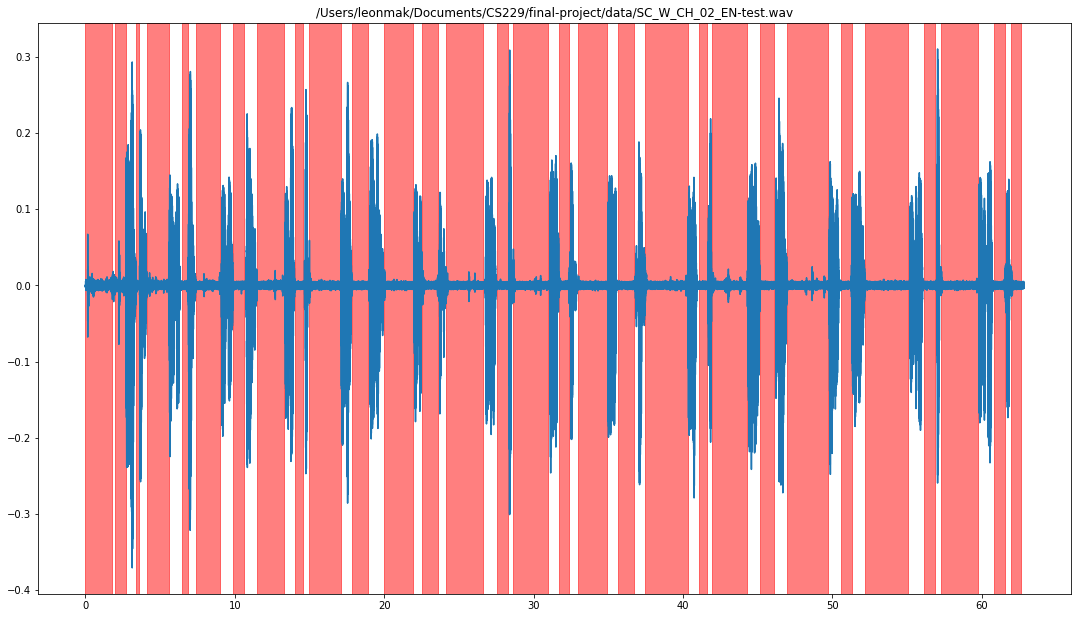

In [50]:
wav_files = ['/Users/leonmak/Documents/CS229/final-project/data/SC_W_CH_02_EN-test.wav']
active, srs, ys = get_segments(wav_files, disp=True)

In [53]:
import scipy.io.wavfile as wav
import time
import glob
import shutil

base_dir = '/Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/'  # by folder, not enough RAM 
shutil.rmtree(base_dir)
labels = [f for f in os.listdir(base_dir) if '.DS_Store' not in f ]
for label in labels:
    wav_files = glob.glob(os.path.join(base_dir, label, '*.wav'))
    active, srs, ys = get_segments(wav_files)
    output_dir = 'data/SC-word-segments'
    os.makedirs(output_dir, exist_ok=True)
    for tplist, fp, y, sr in list(zip(active, wav_files, ys, srs)):
        print(f'{len(tplist)} files in {fp}')
        fname = os.path.basename(fp).split('.')[0]
        label_name = fp.split('/')[-2]
        fdir = os.path.join(output_dir, label_name)
        os.makedirs(fdir, exist_ok=True)
        for tp in tplist:
            start, end = tp
            t_start, t_end = start/sr, end/sr
            output_path = os.path.join(fdir, f'{fname}-{t_start:03.2f}-{t_end:03.2f}.wav')
            wav.write(output_path, 22050, y[start:end])
    time.sleep(3)
    print(f'Done {label}')


467 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_01_EN.wav
390 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_02_EN.wav
276 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_03_EN.wav
433 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_04_EN.wav
416 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_05_EN.wav
405 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_06_EN.wav
371 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_07_EN.wav
387 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_08_EN.wav
405 files in /Users/leonmak/Documents/CS229/final-project/data/SC-orig-scripted-word/CH/SC_W_CH_09_EN.wav
279 files in /Users/leonmak/Documents/CS229/fi

Done TU
